In [11]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define the image size and the number of classes
img_size = 128
num_classes = 2

# Define the train and test directories
train_dir = r"/home/jsmith/Desktop/JohnSmith_AssignmentMidtermProject/Data/train"
test_dir = r"/home/jsmith/Desktop/JohnSmith_AssignmentMidtermProject/Data/test"

# Define the classes
classes = ['DME', 'DRUSEN']

# Create empty lists to store the data and labels
train_data = []
train_labels = []
test_data = []
test_labels = []

# Loop through the train directory to get the images and labels
for class_index, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_size, img_size))
        train_data.append(image)
        train_labels.append(class_index)

# Loop through the test directory to get the images and labels
for class_index, class_name in enumerate(classes):
    class_path = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_size, img_size))
        test_data.append(image)
        test_labels.append(class_index)

# Convert the data and labels to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [12]:
print(train_data[1].shape)

(128, 128, 3)


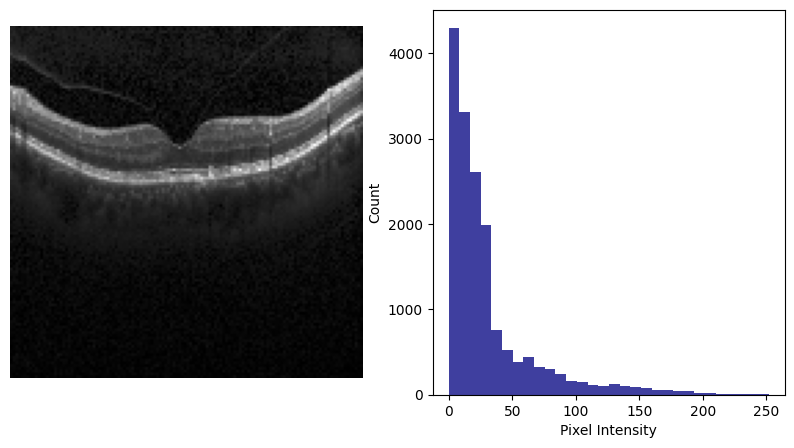

In [13]:
import matplotlib.pyplot as plt

def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
    
plotHistogram(train_data[1])

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras import optimizers

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
optimizer = optimizers.Adam(lr=0.0001)


# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the model and add the top layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
predictions = Dense(num_classes, activation='softmax')
model.add(predictions) # Add predictions layer to the model


# Train top layer
for layer in base_model.layers:
    layer.trainable = False
    
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
from tensorflow import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]
    
# Print the model summary
model.summary()

# Train the model
history = model.fit(train_data, train_labels, batch_size=32, epochs=20, validation_data=(val_data, val_labels))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 15,763,650
Trainable params: 1,048,962
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
335/335 [==============

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_model_results(model, history, test_data, test_labels):
    # Plot accuracy and loss curves
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Val'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='upper left')

    plt.show()

    # Generate predictions for the test data
    y_pred = np.argmax(model.predict(test_data), axis=1)
    y_true = np.argmax(test_labels, axis=1)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = np.arange(len(np.unique(y_true)))
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True Label',
           xlabel='Predicted Label')
    plt.setp(ax.get_xticklabels(),
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show()


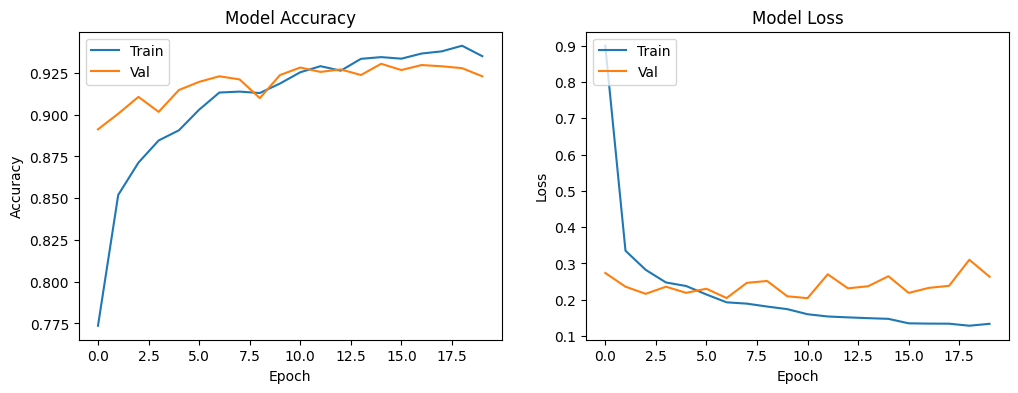

30/30 [==============================] - 2s 51ms/step


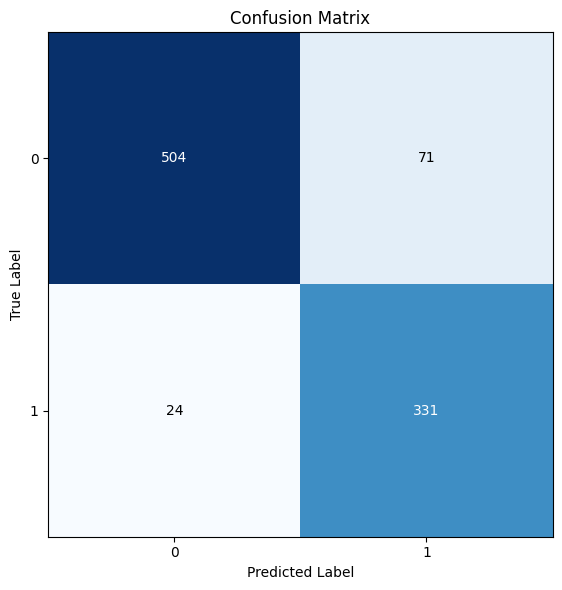

In [16]:
# Plot the model
plot_model_results(model, history, test_data, test_labels)